# 1. Подготовка данных

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore') 
RND = 100423

In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
def select_pd(pd):
    display(pd.head(5))
    display(pd.info())
    display(pd.describe())
    display(pd.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm'))
    display(pd.duplicated().sum())

In [4]:
# Таблица data_arc.csv — данные об электродах
select_pd(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


,0
key,0.00%
Начало нагрева дугой,0.00%
Конец нагрева дугой,0.00%
Активная мощность,0.00%
Реактивная мощность,0.00%


0

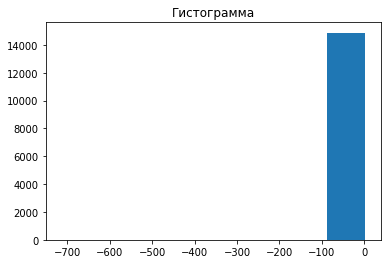

In [5]:
plt.hist(arc['Реактивная мощность'], bins=8)
plt.title('Гистограмма')
plt.show()


Вывод по таблице

У реактивной мощности отрицательные значения. По условиям задания в предобработке мы их уберем.
Столбцы "Начало нагрева дугой" и "Конец нагрева дугой" переведем в тип Datetime
Мы можем создать на основе этой таблицы два признака. а) кпд = активная мощность - реактивная мощность б) полная мощность = корень из суммы квадратов активной и реактивной мощностей.

In [6]:
#  data_bulk.csv — данные о подаче сыпучих материалов (объём)
select_pd(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


,0
key,0.00%
Bulk 14,10.32%
Bulk 12,21.70%
Bulk 15,28.16%
Bulk 3,58.52%
Bulk 4,67.59%
Bulk 6,81.59%
Bulk 1,91.95%
Bulk 11,94.34%
Bulk 10,94.38%


0

Вывод по таблице

Огромное количество пропущенных значений. заменим значения Nan на 0

In [7]:
# bulk_time.csv — данные о подаче сыпучих материалов (время)
select_pd(bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


,0
key,0.00%
Bulk 14,10.32%
Bulk 12,21.70%
Bulk 15,28.16%
Bulk 3,58.52%
Bulk 4,67.59%
Bulk 6,81.59%
Bulk 1,91.95%
Bulk 11,94.34%
Bulk 10,94.38%


0

Вывод по таблице

Огромное количество пропущенных значений. Эту таблицу можем не использовать в моделировании.

In [8]:
# data_wire_time.csv — данные о проволочных материалах (время). Во всех файлах столбец key содержит номер партии.
select_pd(wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


,0
key,0.00%
Wire 1,0.84%
Wire 2,64.98%
Wire 6,97.63%
Wire 3,97.96%
Wire 9,99.06%
Wire 8,99.38%
Wire 4,99.55%
Wire 7,99.64%
Wire 5,99.97%


0

Вывод по таблице

Огромное количество пропущенных значений. Эту таблицу можем не использовать в моделировании.

In [9]:
# data_gas.csv — данные о продувке сплава газом
select_pd(gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


,0
key,0.00%
Газ 1,0.00%


0

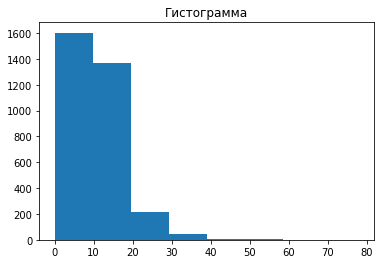

In [10]:
plt.hist(gas['Газ 1'], bins=8)
plt.title('Гистограмма')
plt.show()


In [11]:
# data_temp.csv — результаты измерения температуры
select_pd(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


,0
key,0.00%
Время замера,0.00%
Температура,18.24%


0

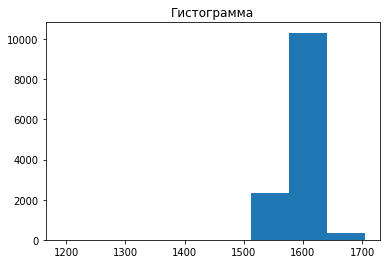

In [12]:
plt.hist(temp['Температура'], bins=8)
plt.title('Гистограмма')
plt.show()


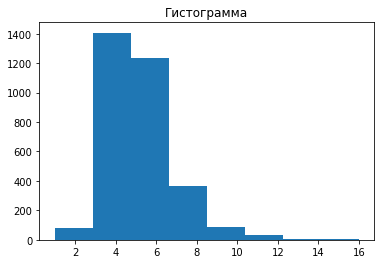

In [13]:
plt.hist((temp['key']).value_counts(), bins=8)
plt.title('Гистограмма')
plt.show()


Вывод по таблице

По условиям задания убираем значения температуры ниже 1500 градусов.
Столбцы "Время замера" переведем в тип Datetime
Заменим пропуски на 0

In [14]:
# data_wire.csv — данные о проволочных материалах (объём)
select_pd(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


,0
key,0.00%
Wire 1,0.84%
Wire 2,64.98%
Wire 6,97.63%
Wire 3,97.96%
Wire 9,99.06%
Wire 8,99.38%
Wire 4,99.55%
Wire 7,99.64%
Wire 5,99.97%


0

Вывод по таблице

Заменим пропуски на 0
На каждую партию приходится несколько замеров температуры. Есть партии, где замеров меньше двух. По устловиям задания эти партии мы в моделировании не рассматриваем.

# Вывод этапа: Подготовка данных
- загрузили библиотеки
- загрузили таблицы и просмотрели каждую из них
- проверили на аномалии(пропуски, дубликаты, выбросы)
- провериили форматы в столбцах
- построили гистограммы
# Во втором этапе нашего проекта мы выполним следующие действия:
# 2. Предобработка данных:
- обработать пропуски и значения Nan (заменить на 0) +
- обработать форматы данных (в таблицах со столбцами с датами заменить тип данных на DateTime) +
- понять, как связаны таблицы между собой проверить на мультиколлинеарность +
- объединить таблицы по столбцу key +
- целевой признак финальная температура *
- нецелевые признаки (кпд, полная мощность) +
- исползовать метрику(MAE). В данном проекте MAE д.б. меньше 6,8.
# 3. Обучение моделей
- Поделить выборку на тренировочную и тестовую в соотношении 25/75
- обучить несколько моделей на тренировочной выборке и выбрать модель для проверки на test (использовать два вида моделей :1. - - Линейную (любую) и 2. Градиентный бустинг (любую).
- проверить модель на тестовой выборке
- сделать выводы


In [18]:
# Заменим значения Nan на 0 в таблицах

bulk = bulk.fillna(0)
temp = temp.fillna(0)
wire = wire.fillna(0)
display(bulk.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm'))

,0
key,0.00%
Bulk 1,0.00%
Bulk 2,0.00%
Bulk 3,0.00%
Bulk 4,0.00%
Bulk 5,0.00%
Bulk 6,0.00%
Bulk 7,0.00%
Bulk 8,0.00%
Bulk 9,0.00%


In [19]:
display(temp.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm'))

,0
key,0.00%
Время замера,0.00%
Температура,0.00%


In [20]:
display(wire.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm'))

,0
key,0.00%
Wire 1,0.00%
Wire 2,0.00%
Wire 3,0.00%
Wire 4,0.00%
Wire 5,0.00%
Wire 6,0.00%
Wire 7,0.00%
Wire 8,0.00%
Wire 9,0.00%


In [21]:
#Обработем форматы данных (в таблицах со столбцами с датами заменить тип данных на DateTime)

arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')  
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S') 
temp['Время замера'] = pd.to_datetime(temp['Время замера'], format='%Y-%m-%dT%H:%M:%S') 

In [22]:
# У реактивной мощности в таблице arc отрицательные значения. По условиям задания в предобработке мы их убираем.

arc = arc.loc[(arc['Реактивная мощность'] > 0)]
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


In [23]:
# Создадим на основе таблицы arc два признака. а) кпд = активная мощность - реактивная мощность б) полная мощность = корень из суммы квадратов активной и реактивной мощностей.

arc['efficiency'] = arc['Активная мощность']-arc['Реактивная мощность']
arc['full power'] = np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)
arc.describe()

,key,Активная мощность,Реактивная мощность,efficiency,full power
count,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723,0.169730,0.838768
std,934.593897,0.408170,0.310880,0.137147,0.509853
min,1.000000,0.030002,0.020806,-1.122256,0.036664
25%,806.000000,0.395295,0.291003,0.085591,0.495322
50%,1617.000000,0.555565,0.415984,0.139564,0.694926
75%,2429.000000,0.857049,0.637403,0.229650,1.066748
max,3241.000000,3.731596,2.676388,1.161038,4.592152


In [25]:
#Проверим признаки на мультиколлинеарность

display(arc[['Активная мощность', 'Реактивная мощность','efficiency', 'full power','key']].corr())

,Активная мощность,Реактивная мощность,efficiency,full power,key
Активная мощность,1.000000,0.963182,0.792845,0.994279,-0.021367
Реактивная мощность,0.963182,1.000000,0.599810,0.986237,-0.000159
efficiency,0.792845,0.599810,1.000000,0.723558,-0.063232
full power,0.994279,0.986237,0.723558,1.000000,-0.013292
key,-0.021367,-0.000159,-0.063232,-0.013292,1.000000


In [28]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3214 non-null   int64  
 1   Активная мощность    3214 non-null   float64
 2   Реактивная мощность  3214 non-null   float64
 3   efficiency           3214 non-null   float64
 4   full power           3214 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 150.7 KB


In [30]:
arc_count = arc.groupby(by = 'key', as_index=False).count()[['key']]
arc = arc.groupby(by = 'key', as_index = False).sum()
arc = arc.merge(arc_count, how='left', on='key')
arc = arc[['key', 'full power']]

arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3214 non-null   int64  
 1   full power  3214 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.3 KB


In [31]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   15907 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [32]:
temp = temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
temp.columns = temp.columns.droplevel()
temp.head()

,,first,last,first,last
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


In [33]:
temp.columns = ['key', 'first', 'last', 'first temp', 'last temp']
temp.head()

,key,first,last,first temp,last temp
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


In [35]:
temp = temp[['key', 'first temp', 'last temp']]
temp.columns

temp['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [36]:
temp = temp.loc[(temp['first temp'] >0)]
temp = temp.loc[(temp['last temp'] >0)]
temp['key'].unique()

array([   1,    2,    3, ..., 2497, 2498, 2499])

In [38]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2477 non-null   int64  
 1   first temp  2477 non-null   float64
 2   last temp   2477 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.4 KB


In [39]:

# Соединим данные в одну таблицу по столбцу key. Берем таблицы arc, temp, bulk, wire, gas

data = arc.merge(temp, how ='left', on ='key')
data = data.merge(bulk, how ='left', on ='key')
data = data.merge(wire, how ='left', on ='key')
data = data.merge(gas, how ='left', on ='key')
data.head()

,key,full power,first temp,last temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,5.826395,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,3.649216,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,2.989534,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,3.814962,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,4.035758,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3214 non-null   int64  
 1   full power  3214 non-null   float64
 2   first temp  2475 non-null   float64
 3   last temp   2475 non-null   float64
 4   Bulk 1      3128 non-null   float64
 5   Bulk 2      3128 non-null   float64
 6   Bulk 3      3128 non-null   float64
 7   Bulk 4      3128 non-null   float64
 8   Bulk 5      3128 non-null   float64
 9   Bulk 6      3128 non-null   float64
 10  Bulk 7      3128 non-null   float64
 11  Bulk 8      3128 non-null   float64
 12  Bulk 9      3128 non-null   float64
 13  Bulk 10     3128 non-null   float64
 14  Bulk 11     3128 non-null   float64
 15  Bulk 12     3128 non-null   float64
 16  Bulk 13     3128 non-null   float64
 17  Bulk 14     3128 non-null   float64
 18  Bulk 15     3128 non-null   float64
 19  Wire 1      3080 non-null  

In [41]:
data = data.rename(columns={'Газ 1': 'Gas'})
data = data.loc[(data['first temp'] >1500)]
data = data.loc[(data['last temp'] >1500)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2474
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2471 non-null   int64  
 1   full power  2471 non-null   float64
 2   first temp  2471 non-null   float64
 3   last temp   2471 non-null   float64
 4   Bulk 1      2403 non-null   float64
 5   Bulk 2      2403 non-null   float64
 6   Bulk 3      2403 non-null   float64
 7   Bulk 4      2403 non-null   float64
 8   Bulk 5      2403 non-null   float64
 9   Bulk 6      2403 non-null   float64
 10  Bulk 7      2403 non-null   float64
 11  Bulk 8      2403 non-null   float64
 12  Bulk 9      2403 non-null   float64
 13  Bulk 10     2403 non-null   float64
 14  Bulk 11     2403 non-null   float64
 15  Bulk 12     2403 non-null   float64
 16  Bulk 13     2403 non-null   float64
 17  Bulk 14     2403 non-null   float64
 18  Bulk 15     2403 non-null   float64
 19  Wire 1      2368 non-null  

In [42]:

data = data.drop(['key'], axis = 1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2474
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   full power  2325 non-null   float64
 1   first temp  2325 non-null   float64
 2   last temp   2325 non-null   float64
 3   Bulk 1      2325 non-null   float64
 4   Bulk 2      2325 non-null   float64
 5   Bulk 3      2325 non-null   float64
 6   Bulk 4      2325 non-null   float64
 7   Bulk 5      2325 non-null   float64
 8   Bulk 6      2325 non-null   float64
 9   Bulk 7      2325 non-null   float64
 10  Bulk 8      2325 non-null   float64
 11  Bulk 9      2325 non-null   float64
 12  Bulk 10     2325 non-null   float64
 13  Bulk 11     2325 non-null   float64
 14  Bulk 12     2325 non-null   float64
 15  Bulk 13     2325 non-null   float64
 16  Bulk 14     2325 non-null   float64
 17  Bulk 15     2325 non-null   float64
 18  Wire 1      2325 non-null   float64
 19  Wire 2      2325 non-null  

In [45]:

data.head()


,full power,first temp,last temp,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Gas
0,5.826395,1571.0,1613.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,3.649216,1581.0,1602.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,2.989534,1596.0,1599.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,3.814962,1601.0,1625.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,4.035758,1576.0,1602.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


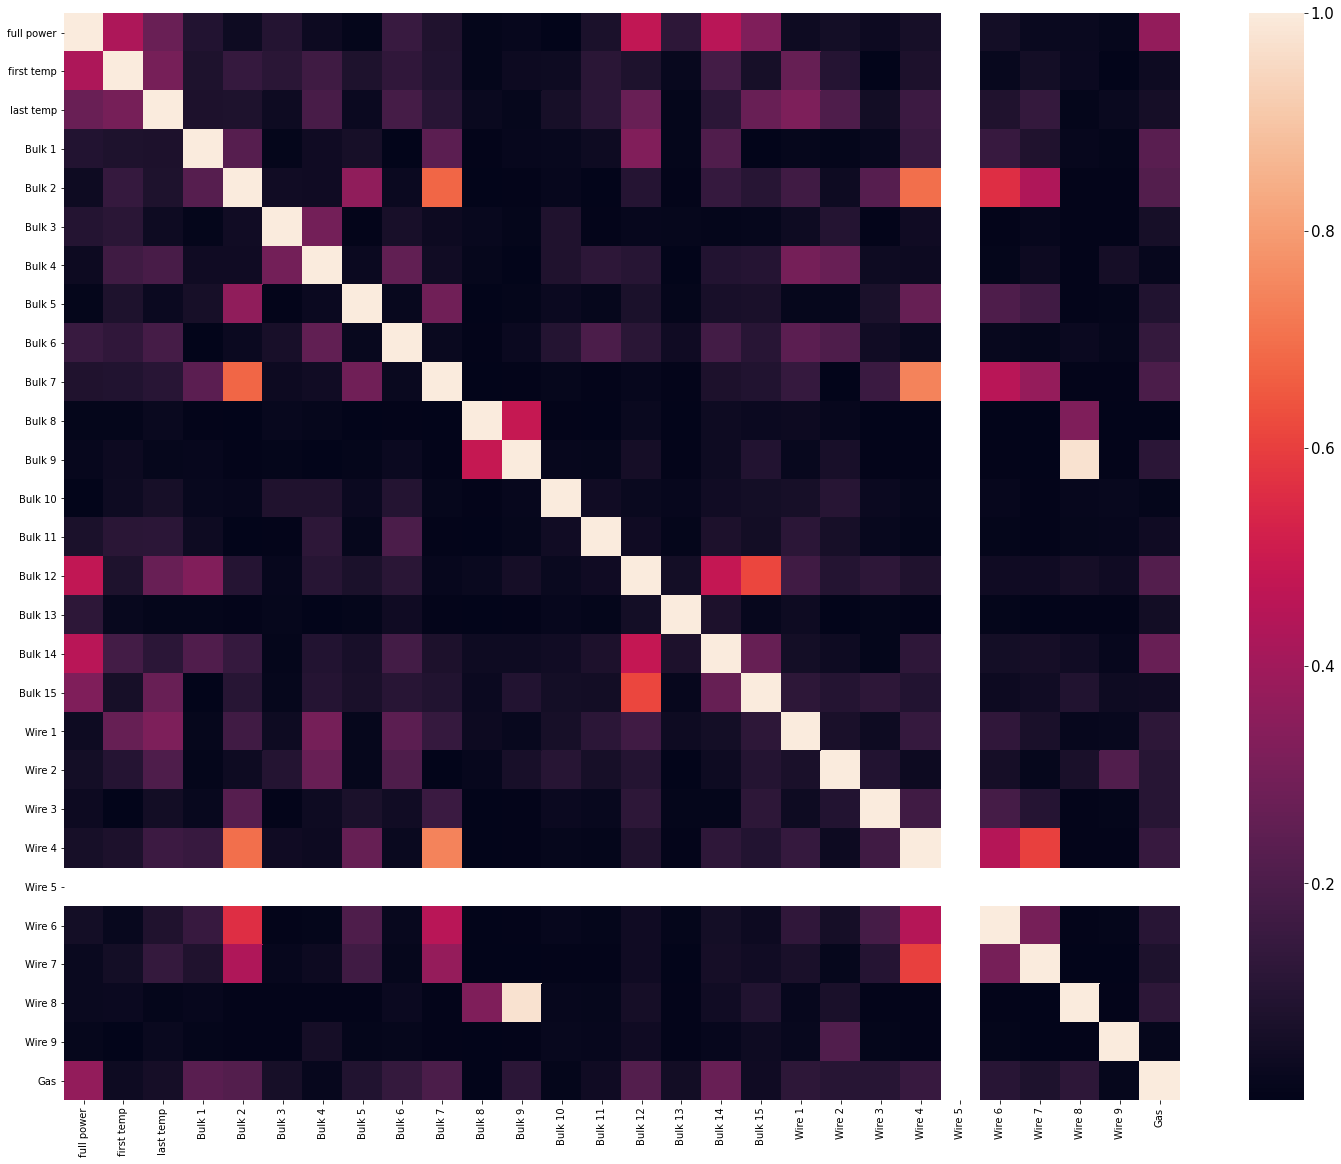

In [46]:
corr = abs(data.corr())

f, ax = plt.subplots(figsize=(25, 20))

font = {'size': 15}
plt.rc('font', **font)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(corr, xticklabels=True, yticklabels=True)

In [47]:
target = data['last temp']
features = data.drop('last temp', axis = 1)
target_train,target_test, features_train, features_test = train_test_split(target,features, test_size = 0.25, random_state = RND)


# Вывод
На данном этапе мы выполнили следующее:

* обработали начения Nan (заменить на 0)
* в таблицах со столбцами с датами заменили тип данных на DateTime
* проверили признаки между собой на мультиколлинеарность
* создали признаки кпд, полная мощность, начатьная температура
* выделили целевой признак финальная температура
* объединили таблицы по столбцу key и затем удалили его из датафрема
* выделили целевой и нецелевые признаки
* разделили таблицу на обучающую и тестовую выборки в соотношении 75/25

Можно приступать к обучению моделей

# 3. Обучение моделей

In [51]:
# LinearRegression()


Line_params = {'fit_intercept':[True,False], 'normalize':[True, False]}

Line_grid = GridSearchCV(LinearRegression(), param_grid = Line_params,  scoring='neg_mean_absolute_error', cv=5)
Line_m = Line_grid.fit(features_train, target_train)
print(f'Лучшая MSE: {-Line_m.best_score_} при параметрах {Line_m.best_params_}')




Лучшая MSE: 6.351796841565643 при параметрах {'fit_intercept': True, 'normalize': True}


In [53]:
cat_params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [RND],
            'max_depth' : [2, 5, 7]
             }
cat_grid = GridSearchCV(CatBoostRegressor(), param_grid = cat_params, scoring='neg_mean_absolute_error', cv=5)
cat_m = cat_grid.fit(features_train, target_train)

print(f'Лучшая MAE: {-cat_m.best_score_} при параметрах {cat_m.best_params_}')


Лучшая MAE: 6.044584504093927 при параметрах {'max_depth': 2, 'n_estimators': 100, 'random_state': 100423, 'verbose': 0}


In [54]:
#Лучший результат на обучающей выборке у модели CatBoostRegressor. Проверим ее на тестовой выборке.


params_cat = cat_grid.best_params_
cat = CatBoostRegressor(**params_cat)
cat.fit(features_train, target_train)
pred_test = cat.predict(features_test)
print(params_cat)
print("MAE on test: ", mean_absolute_error(target_test, pred_test))

{'max_depth': 2, 'n_estimators': 100, 'random_state': 100423, 'verbose': 0}
MAE on test:  6.0908250965423925


#  Вывод
На данном этапе мы выполнили следующее:

* обучили тренировочную выборку на двух моделях LinearRegression() и CatBoostRegressor с использованием кроссвалидации, GridSearchCV и подбором гиперпараметров
* выбрали лучшее значение метрики МАЕ на обучающей выборке CatBoostRegressor 6.04 и проверили ее на тестовой выборке
* получили результат MAE on test: 6.09 при параметрах {'max_depth': 7, 'n_estimators': 100, 'random_state': 100423, 'verbose': 0}

#  Общий вывод
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам было необходимо построить модель, которая предскажет температуру стали.

На первом этапе мы:

* подготовили данные
* загрузили библиотеки
* загрузили таблицы и просмотрели каждую из них
* проверили на аномалии(пропуски, дубликаты, выбросы)
* проверили форматы в столбцах
* построили гистограммы

На втором этапе мы:

* обработали начения Nan (заменить на 0)
* в таблицах со столбцами с датами заменили тип данных на DateTime
* проверили признаки между собой на мультиколлинеарность
* создали признаки кпд, полная мощность, начальная температура
* выделили целевой признак финальная температура
* объединить таблицы по столбцу key и затем удалили его из датафрема
* выделили целевой и нецелевые признаки
* разделили таблицу на обучающую и тестовую выборки в соотношении 75/25

На третьем этапе мы:

* обучили тренировочную выборку на двух моделях LinearRegression() и CatBoostRegressor с использованием кроссвалидации, GridSearchCV и подбором гиперпараметров
* выбрали лучшее значение метрики МАЕ на обучающей выборке CatBoostRegressor 6.13 и проверили ее на тестовой выборке
* получили результат MAE on test: 6.51 при параметрах {{'max_depth': 5, 'n_estimators': 100, 'random_state': 100423, 'verbose': 0}
# Металлургический комбинат ООО «Так закаляем сталь» может смело использовать данную модель в работе.

# Часть три . Отчет о проекте Data Sciece: Машинное обучение для набора данных по предсказанию температуры стали.

### Отчет по проекту :
    Оптимизация производственных расходов металлургического комбината ООО «Так закаляем сталь». 
### Цель проекта:
    Уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки :
 Описание этапа обработки
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

### Описание имеющихся данных:

Данные состоят из файлов, полученных из разных источников:

- data_arc.csv — данные об электродах;
- data_bulk.csv — данные о подаче сыпучих материалов (объём); 
- data_bulk_time.csv — данные о подаче сыпучих материалов (время);
- data_gas.csv — данные о продувке сплава газом;
- data_temp.csv — результаты измерения температуры; 
- data_wire.csv — данные о проволочных материалах (объём);
- data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением Key: они соответствуют разным итерациям обработки.

### Подготовка данных
    Во время этапа изучения и подготовки данных была проведена работа по изучению и удалению аномалий и выбросов в таблицах, приведению в необходимому формату, добавлению признаков для обучения моделей и проведение проверки на мультиколлинеарность этих признаков:
    Была проведена работа по устранению ошибок в данных по значениям реактивной мощности. Так как устранить данную ошибку в формате этого задания не представлялось возможным мы удалили эти значения.
    Мы создали два признака КПД (разница между активной и реактивной мощностью) и полная мощность(корень из сумм квадратов активной и реактивной мощностей). Во время анализа результатов было выявлено отрицательное значение КПД и принято решение отказатться от этого признака, так как неизвестно как он повлияет на обучение.
    После этого мы объединили все данные и убрали все значения температуры до 1500 градусов цельсия.
     Целевым признаком мы обозначили финальное время и разделили наши данные на обучающую и тестовую выборки в соотношении 75/25.
     Метрика, по которой мы будем смотреть на эффективность МАЕ, для нее поставлен порого значения 6,8. Чем меньше метрика при обучении и тестировании моделей, тем ниже вероятность возникновения 
     
### Моделирование  

    Процесс обучения тренировочной выборки происходил на двух моделях: LinearRegression() и CatBoostRegressor() с использованием кроссвалидации, GridSearchCV и подбором гиперпараметров. 
    Выбрали лучшее значение метрики МАЕ на обучающей выборке CatBoostRegressor 6.04 и проверили ее на тестовой выборке получили результат MAE on test: 6.09 при параметрах {{'max_depth': 5, 'n_estimators': 100, 'random_state': 100423, 'verbose': 0}



### Значимость признаков при обучении выбранной модели.

Learning rate set to 0.0447
0:	learn: 11.0954147	total: 3.58ms	remaining: 3.58s
1:	learn: 10.9640196	total: 6.82ms	remaining: 3.4s
2:	learn: 10.8589849	total: 10.1ms	remaining: 3.37s
3:	learn: 10.7353650	total: 13.6ms	remaining: 3.38s
4:	learn: 10.6488474	total: 16.9ms	remaining: 3.36s
5:	learn: 10.5366446	total: 20.6ms	remaining: 3.41s
6:	learn: 10.4336756	total: 23.9ms	remaining: 3.39s
7:	learn: 10.3401084	total: 27.2ms	remaining: 3.37s
8:	learn: 10.2449494	total: 30.7ms	remaining: 3.38s
9:	learn: 10.1481328	total: 33.9ms	remaining: 3.36s
10:	learn: 10.0754302	total: 37.4ms	remaining: 3.36s
11:	learn: 9.9790455	total: 40.8ms	remaining: 3.35s
12:	learn: 9.8926859	total: 44.1ms	remaining: 3.35s
13:	learn: 9.8238342	total: 47.4ms	remaining: 3.33s
14:	learn: 9.7480231	total: 50.7ms	remaining: 3.33s
15:	learn: 9.6799162	total: 54.1ms	remaining: 3.33s
16:	learn: 9.6041208	total: 57.3ms	remaining: 3.31s
17:	learn: 9.5332431	total: 60.7ms	remaining: 3.31s
18:	learn: 9.4652510	total: 63.9ms	r

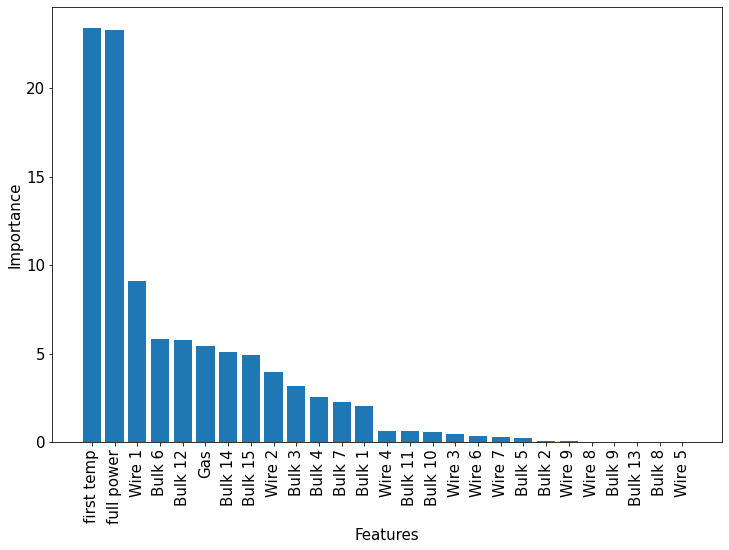

In [59]:
import catboost as cb

train_pool = cb.Pool(data=features_train, label=target_train)

regressor_CBR = cb.CatBoostRegressor()
regressor_CBR.fit(train_pool)
feat_importance = regressor_CBR.get_feature_importance(train_pool)

sorted_idx = np.argsort(feat_importance)[::-1]

# Построение графика значимости признаков
plt.figure(figsize=(12, 8))
plt.bar(range(features_train.shape[1]), feat_importance[sorted_idx])
plt.xticks(range(features_train.shape[1]), features_train.columns[sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


Наиболее значимыми признакими при обучении модели являются начальная температура и полная мощность. Это может быть интерпретировано экспертами и использовано в качестве основы для сбора большего количества данных в будущем.

### Вывод: Представленная модель может быть использована для оптимизации производственных расходов  металлургического комбината ООО «Так закаляем сталь»